In [207]:
import tensorflow as tf

tfk = tf.keras
tfkl = tf.keras.layers
import numpy as np
import matplotlib.pyplot as plt
import os, glob
import tqdm

from astropy.visualization import simple_norm

verbose = True

In [57]:
def load_image_from_path(path):
    """
    Decode a jpg image from the string filepath

    :param path: Path to image
    :return: 3D image tensor
    """
    raw_img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(raw_img, channels=3)
    img = tf.image.convert_image_dtype(img, 'float32') # pre-normalises to 0,1
    
    # # make images black and white - img should keep the same dimensions (i.e.) 64x64x3 -> 64x64x1
    
    return img.numpy()

In [195]:
PATH_TO_DATA = "data/final_64x64_proc"

train_filelist = glob.glob(os.path.join(PATH_TO_DATA, "TRAIN", "*.jpg"))
val_filelist = glob.glob(os.path.join(PATH_TO_DATA, "VAL", "*.jpg"))

# Adjust according to how long it's taking.
SUBSAMPLE = 1

if SUBSAMPLE > 1:
    train_filelist = train_filelist[:len(train_filelist) // SUBSAMPLE]
    val_filelist = val_filelist[:len(val_filelist) // SUBSAMPLE]
    
train_data = np.array([load_image_from_path(f) for f in tqdm.tqdm(train_filelist, desc='Processing training data')])
val_data = np.array([load_image_from_path(f) for f in tqdm.tqdm(val_filelist, desc='Processing validation data')])

Processing validation data: 100%|██████████| 1539/1539 [00:00<00:00, 2713.98it/s]


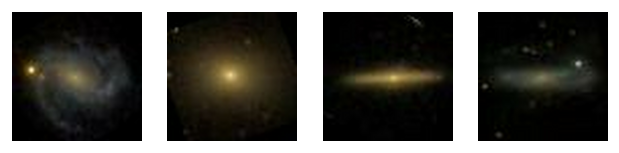

In [196]:
# plot some examples
N_EXAMPLES = 4
random_idx_seed = np.random.randint(0, len(val_data), N_EXAMPLES)

fig, ax = plt.subplots(1, N_EXAMPLES, dpi=120)

for i, idx in enumerate(random_idx_seed):
  ax[i].imshow(train_data[idx], interpolation='lanczos')
  ax[i].axis("off")

In [214]:
CODE_DIM = 64

# dense auto-encoder
# inputs = tf.keras.Input(shape=(train_data.shape[1:]))
# x = tf.keras.layers.Flatten()(inputs)
# x = tf.keras.layers.Dense(32, activation='linear')(x)
# x = tf.keras.layers.Dense(CODE_DIM, activation='linear')(x)
# x = tf.keras.layers.Dense(32, activation='linear')(x)
# x = tf.keras.layers.Dense(train_data.shape[1] * train_data.shape[2] * train_data.shape[3], activation='linear')(x)
# outputs = tf.keras.layers.Reshape((train_data.shape[1:]))(x)
# autoenc = tf.keras.Model(inputs=inputs, outputs=outputs, name='autoenc')

# convolutional auto-encoder
input_shape = train_data.shape[1:]
code_dim = CODE_DIM  # Define your code dimension

inputs = tfkl.Input(shape=input_shape)

x = tfkl.Conv2D(64, 3, padding='same', activation='relu')(inputs)
x = tfkl.Conv2D(64, 3, padding='same', activation='relu')(x)
x = tfkl.MaxPooling2D(pool_size=(2, 2), padding='same')(x)
x = tfkl.BatchNormalization()(x)

x = tfkl.Conv2D(32, 3, padding='same', activation='relu')(x)
x = tfkl.Conv2D(32, 3, padding='same', activation='relu')(x)
x = tfkl.MaxPooling2D(pool_size=(2, 2), padding='same')(x)
x = tfkl.BatchNormalization()(x)

x = tfkl.Conv2D(16, 3, padding='same', activation='relu')(x)
x = tfkl.Conv2D(16, 3, padding='same', activation='relu')(x)
x = tfkl.MaxPooling2D(pool_size=(4, 4), padding='same')(x)
x = tfkl.BatchNormalization()(x)

x = tfkl.Conv2D(16, 3, padding='same', activation='relu')(x)
x = tfkl.Conv2D(16, 3, padding='same', activation='relu')(x)
x = tfkl.MaxPooling2D(pool_size=(4, 4), padding='same')(x)
x = tfkl.BatchNormalization()(x)

x = tfkl.Dense(code_dim, name='bottleneck')(x)

x = tfkl.Conv2D(16, 3, padding='same', activation='relu')(x)
x = tfkl.Conv2D(16, 3, padding='same', activation='relu')(x)
x = tfkl.UpSampling2D(size=(4, 4), interpolation='bilinear')(x)
x = tfkl.BatchNormalization()(x)

x = tfkl.Conv2D(16, 3, padding='same', activation='relu')(x)
x = tfkl.Conv2D(16, 3, padding='same', activation='relu')(x)
x = tfkl.UpSampling2D(size=(4, 4), interpolation='bilinear')(x)
x = tfkl.BatchNormalization()(x)

x = tfkl.Conv2D(32, 3, padding='same', activation='relu')(x)
x = tfkl.Conv2D(32, 3, padding='same', activation='relu')(x)
x = tfkl.UpSampling2D(size=(2, 2), interpolation='bilinear')(x)
x = tfkl.BatchNormalization()(x)

x = tfkl.Conv2D(64, 3, padding='same', activation='relu')(x)
x = tfkl.Conv2D(64, 3, padding='same', activation='relu')(x)
x = tfkl.UpSampling2D(size=(2, 2), interpolation='bilinear')(x)
x = tfkl.BatchNormalization()(x)

outputs = tfkl.Conv2D(3, 3, activation='sigmoid', padding='same')(x)

autoenc = tf.keras.Model(inputs, outputs)

### Compiling the model
In this cell we 'compile' the model into a compute graph ready to execute. In each line we:
* Specify the 'optimiser' algorithm [\[see here\]](https://keras.io/api/optimizers/) and the 'learning rate', i.e. the size of the steps we take.
* The loss function: how well our model reconstructs the data - here we use the mean-squared error sum(square(x_pred - x_true))
* Any other "metrics" we want to compute as we go. Here I've added the mean absolute error for example

In [215]:
opt = tf.keras.optimizers.Adam(learning_rate=3e-4)
loss = tf.keras.losses.MeanSquaredError()
autoenc.compile(optimizer=opt, loss=loss, metrics=["mae"])

### Training
This cell does the model training - we pass a lot of arguments here, so step by step:
* EarlyStopping: this monitors the validation loss, and stops training if it doesn't improve for 25 rounds of training. Upon stopping, it'll restore the best version of the model we found during training
* `.fit()` calls the fitting routine on the `train_data`, with the inputs `x` and `y` being the same since we're training an autoencoder. We use the `val_data` as validation data, to monitor our progress and avoid overfitting. We use a `batch_size` of 16 - this is how many examples we train on at a time. The larger this is the more stable the gradient updates, but has a higher computational overhead. We have to attach the `EarlyStopping` routine we defined to the fitting routine, and we do this via callbacks

In [216]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
history = autoenc.fit(x=train_data, y=train_data, epochs=100, verbose=1, 
                    validation_data=(val_data, val_data), batch_size=16, callbacks=[early_stop,])

Epoch 1/100
 70/866 ━━━━━━━━━━━━━━━━━━━━ 1:55 145ms/step - loss: 0.1864 - mae: 0.3781

KeyboardInterrupt: 

### How did training go?
We can here plot the loss and validation loss during training to see that everything went as expected.

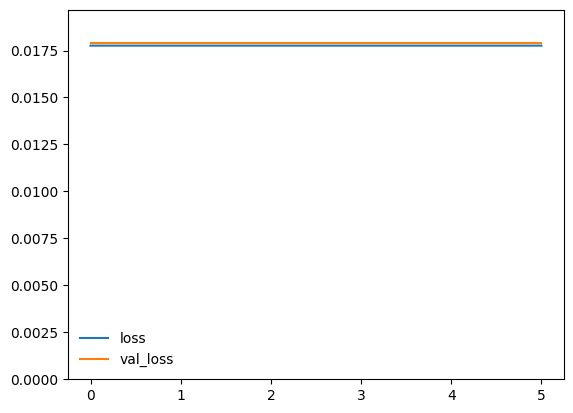

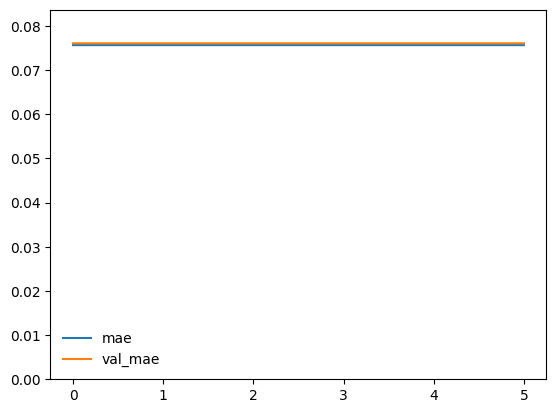

In [212]:
plt.plot(history.epoch, history.history["loss"], label='loss')
plt.plot(history.epoch, history.history["val_loss"], label='val_loss')
plt.ylim(0, 1.1*np.percentile(history.history["val_loss"], 95))
plt.legend(frameon=False)
plt.show()

plt.plot(history.epoch, history.history["mae"], label='mae')
plt.plot(history.epoch, history.history["val_mae"], label='val_mae')
plt.ylim(0, 1.1*np.percentile(history.history["val_mae"], 95))
plt.legend(frameon=False)
plt.show()

### Did we succeed?
Let's check how we did in encoding the galaxies. In this cell, we predict the outputs of the autoencoder on our validation set. If all has worked well, we should see galaxies!

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


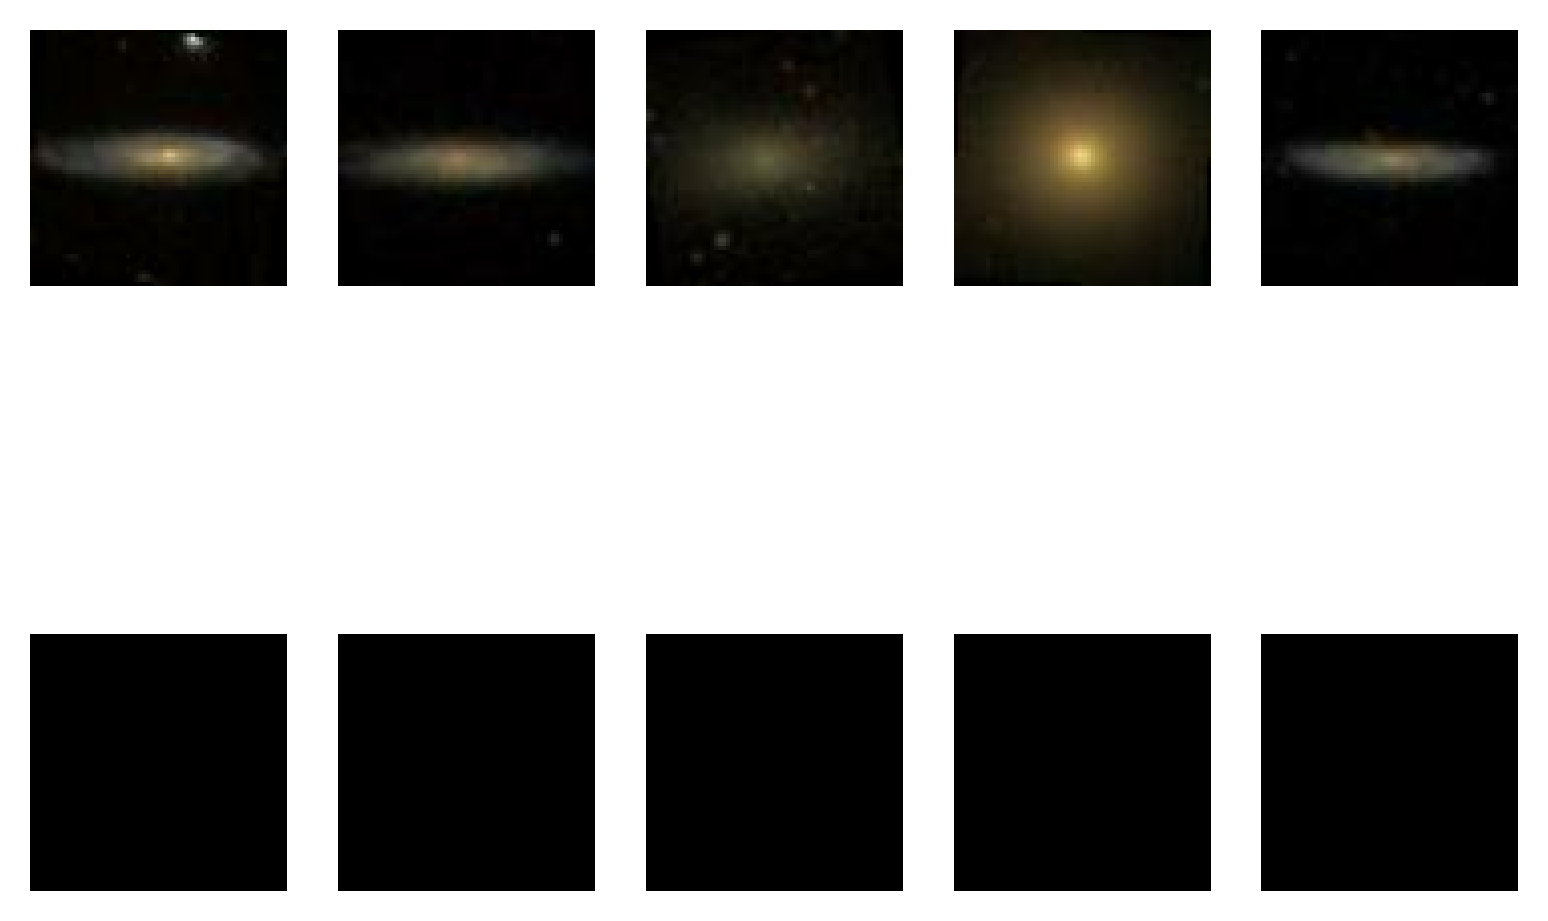

In [213]:
reproduction = autoenc.predict(val_data)

fig, ax = plt.subplots(2, 5, dpi=300)

random_idx_seed = np.random.randint(0, len(val_data), 5)

for i, val in enumerate(random_idx_seed):
  ax[0][i].imshow(val_data[val])
  ax[0][i].axis("off")
  ax[1][i].imshow(reproduction[val])
  ax[1][i].axis("off")

In [202]:
autoenc.save("autoenc.h5")